In [2]:
# Setup Docker (including Colab) environment

import sys
from pathlib import Path
if Path('/.dockerenv').exists():
    !apt install cmake libopenmpi-dev zlib1g-dev
    !pip install git+https://github.com/RerRayne/stable-baselines

    !git clone https://github.com/Pastafarianist/rl-attention.git
    
    sys.path.append('rl-attention')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
  Cloning https://github.com/RerRayne/stable-baselines to /tmp/pip-req-build-rmfejb74
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2m04obl/wheels/f0/dc/5f/fe56f5d8f0c71b8e8e9f2e6f528b6793daf6af48eebccc1742
Successfully built stable-baselines
fatal: destination path 'rl-attention' already exists and is not an empty directory.


In [11]:
import json
import logging
import os
import random
import time
from datetime import datetime
from pprint import pprint

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from stable_baselines import A2C
from stable_baselines.common import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize
from stable_baselines.results_plotter import load_results, ts2xy

from models import attention_cnn

from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

log_dir = Path("/content/gdrive/My Drive/rl-attention_tensorboard_logs/")
log_dir.mkdir(exist_ok=True)
saved_params_dir = Path("/content/gdrive/My Drive/rl-attention_saved_params/")
saved_params_dir.mkdir(exist_ok=True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
class Callback(object):
    def __init__(self):
        self.best_mean_reward = -np.inf
        self.n_steps = 0
    
    def __call__(self, _locals, _globals):
        """
        Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
        :param _locals: (dict)
        :param _globals: (dict)
        """
        if self.n_steps % 100 == 1:
            # Display frames
            plt.grid(None)
            plt.imshow(_locals["self"].env.render(mode='rgb_array'))
            plt.show()
            print("nsteps", self.n_steps)
            #pprint(_locals['self'].graph.get_collection("trainable_variables"))
            
            # Save current parameters to Google drive
            model_save_target = "GDRIVE"
            model_save_filename = "params-" + datetime.now().strftime('%Y-%m-%d_%H:%M:%S') + ".pkl"
            
            if model_save_target == "GDRIVE":
                _locals['self'].save(str(Path(saved_params_dir, model_save_filename)))
            else:
                model_save_filepath = str(Path("/tmp/", model_save_filename))
                _locals['self'].save(model_save_filepath)
                files.download(model_save_filepath)

        self.n_steps += 1
        return True

Saving params-2019-04-21_18_50_34.pkl to params-2019-04-21_18_50_34 (1).pkl
UPLOADED FILENAME params-2019-04-21_18_50_34.pkl
/content
---------------------------------
| explained_variance | -430     |
| fps                | 193      |
| nupdates           | 1        |
| policy_entropy     | 1.79     |
| total_timesteps    | 81       |
| value_loss         | 4.51e-05 |
---------------------------------


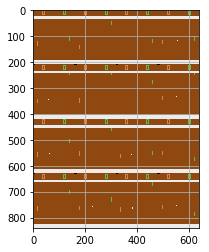

nsteps 1


Process ForkProcess-139:
Process ForkProcess-135:
Process ForkProcess-133:
Process ForkProcess-140:
Process ForkProcess-138:
Process ForkProcess-137:
Process ForkProcess-129:


KeyboardInterrupt: ignored

Process ForkProcess-136:
Process ForkProcess-134:
Process ForkProcess-144:
Process ForkProcess-131:
Process ForkProcess-130:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-141:
Process ForkProcess-143:
Process ForkProcess-132:
Process ForkProcess-142:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):


In [16]:
env = make_atari_env('PongNoFrameskip-v4', num_env=16, seed=0)
env = VecFrameStack(env, n_stack=4) # stack 4 frames

# TODO: perhaps the below can be packaged up into a nice .py file with different types of training algorithms etc.

model_params_source = 'UPLOAD' # or: 'UPLOAD' or 'GDRIVE'

if model_params_source == 'UPLOAD':
    uploaded_files = files.upload()  # will save the file to the /content folder
    uploaded_filename = list(uploaded_files.keys())[0]
    model = A2C.load(
        uploaded_filename,
        env,
        prioritized_replay=True,
        param_noise=True,
        policy_kwargs={'cnn_extractor': attention_cnn}
    )
    
elif model_params_source == 'GDRIVE':
    model = A2C.load(
        str(Path(saved_params_dir, "./params-2019-04-21_18:50:34.pkl")),
        env,
        prioritized_replay=True,
        param_noise=True,
        policy_kwargs={'cnn_extractor': attention_cnn}
    )   
    
elif model_params_source == 'FRESH':
    model = A2C(
        CnnPolicy,
        env,
        lr_schedule='constant',
        verbose=1,
        policy_kwargs={'cnn_extractor': attention_cnn}
    )
callback = Callback()

model.learn(total_timesteps=int(1e7), callback=callback)